In [ ]:
%load_ext autoreload
%autoreload 2

import json
import os
import pickle
from collections import defaultdict
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams
from matplotlib.lines import Line2D

from plot_utils import load_chid

In [ ]:
    
from rdkit import Chem
from rdkit.Chem import Draw
# from svglib.svglib import svg2rlg
# from reportlab.graphics import renderPDF

from IPython.display import display, SVG
def forfor(a):
    return [item for sublist in a for item in sublist]

def m7s(smiles):
    return Chem.MolFromSmiles(smiles)

from sklearn.neighbors import NearestNeighbors
def get_dists(X, Y):
    neigh = NearestNeighbors(10, 0.4, metric='jaccard', algorithm='brute')
    neigh.fit(X)
    dist, idx = neigh.kneighbors(Y)
    return dist, idx

from utils import ecfp
from collections import Counter

RDKit WARNING: [13:11:54] Enabling RDKit 2019.09.1 jupyter extensions


In [ ]:
# rcParams.update(matplotlib.rcParamsDefault)
params = {
    #    'axes.labelsize': 8,
    'font.size': 14,

    #    'legend.fontsize': 14,
    #    'xtick.labelsize': 10,
    #    'ytick.labelsize': 10,
    'text.usetex': False,
    #    'figure.figsize': [4.5, 4.5]
}
rcParams.update(params)

columns = ['AssayID', 'TargetName', 'TargetID']
rows = [('CHEMBL3888429', 'JAK2', 'CHEMBL2971'),
        ('CHEMBL1909203', 'EGFR', 'CHEMBL203'),
        ('CHEMBL1909140', 'DRD2', 'CHEMBL217')]

assay_info = pd.DataFrame(rows, columns=columns)
chid2name = dict(zip(assay_info['AssayID'], assay_info['TargetName']))

order = ('Split1', 'Split2', 'Split1_alt')
col_dict = dict(zip(order, ['blue', 'red', 'green']))
col_dict2 = dict(zip(order, ['cyan', 'magenta', 'green']))
legend_dict = dict(zip(order, ['Optimization', 'Data control', 'Model control']))
chids = ['CHEMBL3888429', 'CHEMBL1909203', 'CHEMBL1909140']

In [ ]:
def get_nn(si, so):
    smiles_train = list(si[si['Split'] == 0].smiles)
    smiles_test = list(si[si['Split'] == 1].smiles)

    ecfp_train = np.array(ecfp(smiles_train), dtype=bool)
    ecfp_test = np.array(ecfp(smiles_test), dtype=bool)
    ecfp_opt = np.array(ecfp(so), dtype=bool)

    # get nearest neighbours and distances
    dist_train, idx_train = get_dists(ecfp_train, ecfp_opt)
    dist_test, idx_test = get_dists(ecfp_test, ecfp_opt)

    nnd_train = dist_train[:,0]
    nnd_test = dist_test[:,0]

    nn_train = [smiles_train[i] for i in idx_train[:,0]]
    nn_test = [smiles_test[i] for i in idx_test[:,0]]
    return nnd_train, nnd_test, nn_train, nn_test

In [ ]:
chid2name

{'CHEMBL3888429': 'JAK2', 'CHEMBL1909203': 'EGFR', 'CHEMBL1909140': 'DRD2'}

In [ ]:
results_dir = Path('./results/goal_directed_v2/')

results = {}
for optimizer in ['graph_ga', 'lstm_hc']:
    if optimizer in results:
        continue
    
    results[optimizer] = {}
    for chid in chids:
        chid_path = results_dir/optimizer/chid
        print(chid_path)
        # split info contains information about the data splits. a list of dataframes
        preds_internal, preds_external, auc, smiles, split_info = load_chid(Path(chid_path), order)

        # predictions of last iteration for all runs [10, nsamples]
        preds1 = [p[-1] for p in preds_internal['Split1']]
        preds2 = [p[-1] for p in preds_internal['Split2']]

        # final optimized smiles [10, nsamples]
        smiles_opt = [sl[-1] for sl in smiles]

        # for each run calculate nearest neighbours
        accumulate = []
        for si, so in zip(split_info, smiles_opt):
            accumulate.append(get_nn(si, so))

        nnd_train, nnd_test, nn_train, nn_test = zip(*accumulate)
        results[optimizer][chid] = (smiles_opt, preds1, preds2, nnd_train, nnd_test, nn_train, nn_test)
    
  

results/goal_directed_v2/graph_ga/CHEMBL3888429
results/goal_directed_v2/graph_ga/CHEMBL1909203
results/goal_directed_v2/graph_ga/CHEMBL1909140
results/goal_directed_v2/lstm_hc/CHEMBL3888429
results/goal_directed_v2/lstm_hc/CHEMBL1909203
results/goal_directed_v2/lstm_hc/CHEMBL1909140


graph_ga
0.011, 0.018
0.170, 0.145
0.146, 0.165
lstm_hc
0.036, 0.033
0.077, 0.064
0.086, 0.033


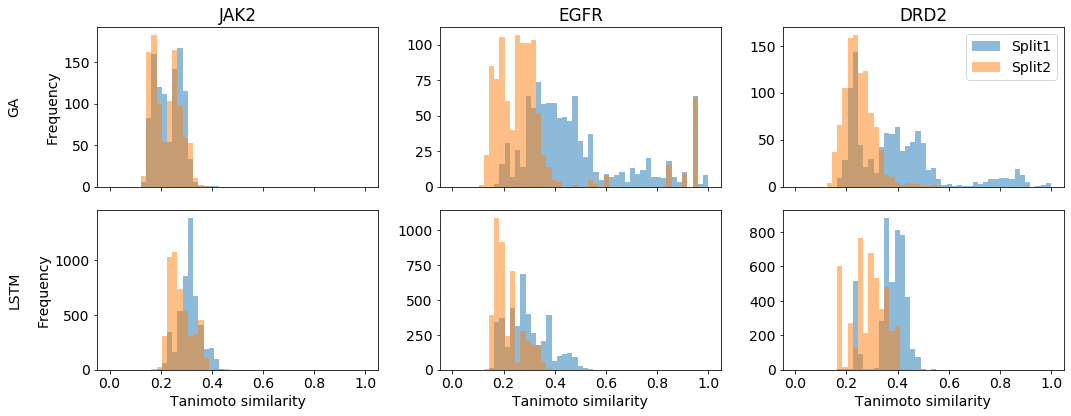

In [ ]:
xlabel = None
title = True

fig, axes = plt.subplots(nrows=2, ncols=len(chids), figsize=(15, 6), sharex=True)

for r_idx, (optimizer, opt_results) in enumerate(results.items()):
    print(optimizer)
    ymax = -1e15
    ylabel='Frequency'
    for c_idx, (chid, values) in enumerate(opt_results.items()):
        
        ax = axes[r_idx][c_idx]
        smiles_opt, preds1, preds2, nnd_train, nnd_test, nn_train, nn_test = values
        bins = np.linspace(0,1,50)
        alpha=0.5
        sims_train = 1-np.array(forfor(nnd_train))
        sims_test = 1-np.array(forfor(nnd_test))
        if (r_idx, c_idx) == (0, 2):
            label1, label2 = 'Split1', 'Split2'
        else:
            label1, label2 = None, None
            
        ax.hist(sims_train, bins=bins, alpha=alpha, label=label1)
        ax.hist(sims_test, bins=bins, alpha=alpha, label=label2)
        diff = sims_train-sims_test
        mean_diff = np.mean(diff)
        std_diff = np.std(diff)
        print(f"{mean_diff:.3f}, {std_diff:.3f}")
        if (r_idx, c_idx) == (0, 2):
#             ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.35), frameon=False, fontsize=16)
            ax.legend()
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ylabel=None
        if title:
            ax.set_title(chid2name[chid])
    title = False
    xlabel = 'Tanimoto similarity'
xtext = -0.4


# custom_lines = []
# fig.legend(custom_lines, list(legend_dict.values()), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.03), frameon=False, fontsize=16)

axes[0][0].text(xtext, sum(axes[0][0].get_ylim()) / 2 , "GA", rotation=90, verticalalignment='center')
axes[1][0].text(xtext, sum(axes[1][0].get_ylim()) / 2, "LSTM", rotation=90, verticalalignment='center')
plt.tight_layout()
plt.savefig('./figures/NND_hist.pdf')

graph_ga
lstm_hc


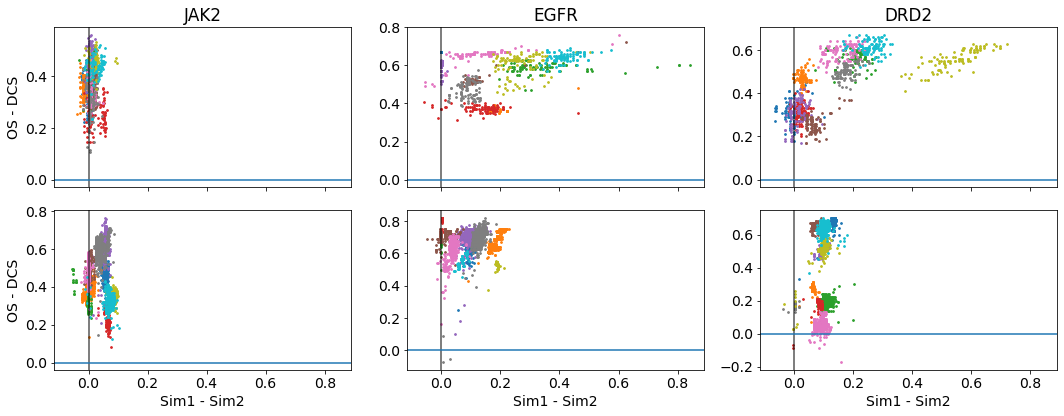

In [ ]:
xlabel = None
title = True

fig, axes = plt.subplots(nrows=2, ncols=len(chids), figsize=(15, 6), sharex=True)

for r_idx, (optimizer, opt_results) in enumerate(results.items()):
    print(optimizer)
    ymax = -1e15
    ylabel='OS - DCS'
    for c_idx, (chid, values) in enumerate(opt_results.items()):
        ax = axes[r_idx][c_idx]
        smiles_opt, preds1, preds2, nnd_train, nnd_test, nn_train, nn_test = values
        
        for d1, d2, p1, p2 in  zip(nnd_train, nnd_test, preds1, preds2):
            ax.scatter(-d1+d2, np.array(p1)-np.array(p2), s=3)
    
        ax.axvline(0, ymin=-1, ymax=1, c='black', lw=2, alpha=0.5)
        ax.axhline(0, xmin=-1, xmax=1)
#         plt.plot([-1,1], [-1,1], c='black', lw=2, alpha=0.5)
# #         plt.xlim((-0.1,1))
# #         plt.ylim((0,1))
#         plt.xlabel('Distance difference')
#         plt.ylabel('Prediction difference')
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ylabel=None
        if title:
            ax.set_title(chid2name[chid])
    title = False
#         _, yh = ax.get_ylim()
#         ymax = max(yh, ymax)
#         print(ymax)
#     for ax in axes[r_idx]:
#         ax.set_ylim((0,ymax))
    xlabel = 'Sim1 - Sim2'
#         plt.ylabel('Frequency')
#         plt.title(chid2name[chid])
#         plt.legend()
#         plt.show()
plt.tight_layout()